In [ ]:
import os, time, segyio
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
import keras.backend as K
from keras import Model, Input
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*60+'\n')
    return None

check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [4]:
def plot_loss(data, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(data.history['loss'], label='train')
    plt.plot(data.history['val_loss'], label='validation')
    plt.legend(); plt.grid(True, which='both')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    return None

In [5]:
# slb_flat = np.moveaxis(segyio.tools.cube(segyio.open('Fault identification/Schlumberger synthetic models/Schlumberger_800_SLB_Force_Fault_Model_Flat_Noisy_Amplitude.segy')), -1, 1)
# slb_hybrid = np.moveaxis(segyio.tools.cube(segyio.open('Fault identification/Schlumberger synthetic models/Schlumberger_800_SLB_Force_Fault_Model_Hybrid_Noisy_Amplitude.segy')), -1, 1)
# slb_circular = np.moveaxis(segyio.tools.cube(segyio.open('Fault identification/Schlumberger synthetic models/Schlumberger_800_SLB_Force_Fault_Model_Circular_Noisy_Amplitude.segy')), -1, 1)
# slb_fault = np.moveaxis(segyio.tools.cube(segyio.open('Fault identification/Schlumberger synthetic models/Schlumberger_800_SLB_Force_Fault_Model_IsFault.segy')), -1, 1)
# print('Flat: {} | Hybrid: {} | Circular: {} | Fault: {}'.format(slb_flat.shape, slb_hybrid.shape, slb_circular.shape, slb_fault.shape))

# my_cmap = 'seismic'
# fig, axs = plt.subplots(3, 10, figsize=(20,6), sharex=True, sharey=True)
# for j in range(10):
#     k = j * 10
#     ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
#     ax1.imshow(slb_flat[k], cmap=my_cmap)
#     ax2.imshow(slb_hybrid[k], cmap=my_cmap)
#     ax3.imshow(slb_circular[k], cmap=my_cmap)
#     [a.imshow(slb_fault[k], cmap='binary', alpha=0.4) for a in axs[:,j]]
#     [a.set(xticks=[], yticks=[], title='Slice {}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
#     [a.set_ylabel(['Flat','Hybrid','Circular'][i], color='k') for i, a in enumerate(axs[:,0])]
# plt.tight_layout()
# plt.show()

PP: (101, 751, 589) | AI: (101, 751, 589) | Fault: (101, 751, 589)


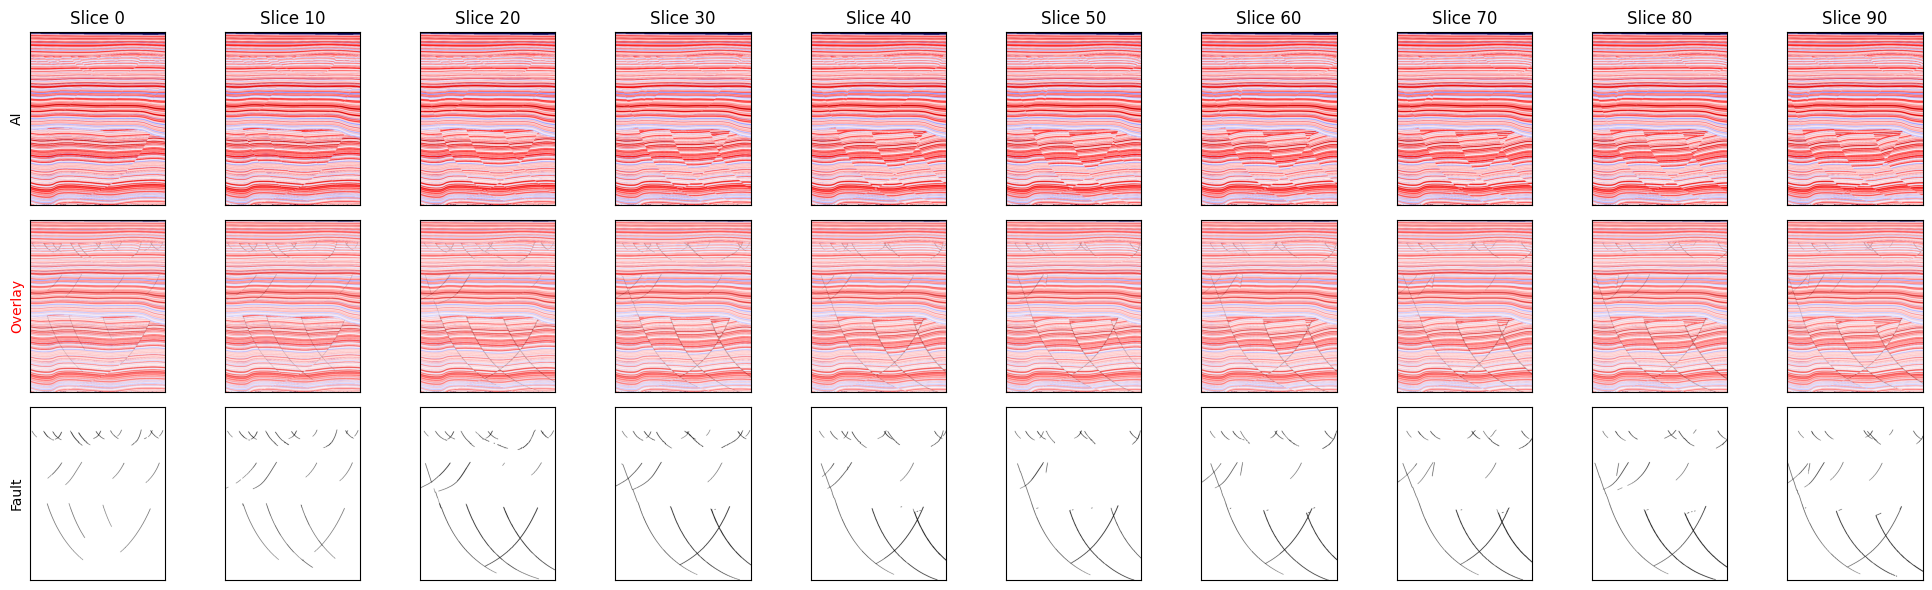

In [6]:
equinor_pp = np.rot90(segyio.tools.cube(segyio.open('Fault identification/Equinor Synthetic model/issap20_Pp.sgy', xline=181)), axes=(1,2), k=3)
equinor_ai = np.rot90(segyio.tools.cube(segyio.open('Fault identification/Equinor Synthetic model/issap20_AI.sgy', xline=181)), axes=(1,2), k=3)
equinor_fault = np.rot90(segyio.tools.cube(segyio.open('Fault identification/Equinor Synthetic model/issap20_Fault.sgy', xline=181)), axes=(1,2), k=3)
print('PP: {} | AI: {} | Fault: {}'.format(equinor_pp.shape, equinor_ai.shape, equinor_fault.shape))

fig, axs = plt.subplots(3, 10, figsize=(20, 6), sharex=True, sharey=True)
for j in range(10):
    k = j * 10
    ax1, ax2, ax3 = axs[0, j], axs[1, j], axs[2, j]
    ax1.imshow(equinor_ai[k], cmap='seismic')
    ax2.imshow(equinor_ai[k], cmap='seismic')
    ax2.imshow(equinor_fault[k], cmap='binary', alpha=0.25)
    ax3.imshow(equinor_fault[k], cmap='binary')
    [a.set(xticks=[], yticks=[], title='Slice {}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
    [a.set_ylabel(['AI','Overlay','Fault'][i], color=['k','r','k'][i]) for i, a in enumerate(axs[:,0])]
plt.tight_layout()
plt.show()

In [7]:
# reshape
X_data = np.moveaxis(np.pad(equinor_ai, ((0,0),(8,9),(0,0)), mode='constant', constant_values=0)[:,:,38:-39].reshape(-1, 3, 256, 512).reshape(-1,256,256,2), -1, 1).reshape(-1,256,256,1)
Y_data = np.moveaxis(np.pad(equinor_fault, ((0,0),(8,9),(0,0)), mode='constant', constant_values=0)[:,:,38:-39].reshape(-1, 3, 256, 512).reshape(-1,256,256,2), -1, 1).reshape(-1,256,256,1)

# normalize
X_data = (X_data - X_data.min()) / (X_data.max() - X_data.min())
Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.174)
print('Train - X: {} | Y: {}\nTest  - X: {} | Y: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train - X: (500, 256, 256, 1) | Y: (500, 256, 256, 1)
Test  - X: (106, 256, 256, 1) | Y: (106, 256, 256, 1)


In [8]:
def make_model(dim=256):
    def conv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = Conv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = BatchNormalization()(_)
        _ = Activation('relu')(_)
        _ = MaxPooling2D(pool_size=pool)(_)
        return _
    
    def deconv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = Conv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = BatchNormalization()(_)
        _ = Activation('relu')(_)
        _ = UpSampling2D(size=pool)(_)
        return _
    
    inp = Input(shape=(dim,dim,1))
    # encoder
    x = conv_block(inp, 16)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    # decoder
    x = deconv_block(x, 256)
    x = deconv_block(x, 128)
    x = deconv_block(x, 64)
    x = deconv_block(x, 16)
    # model
    out = SeparableConv2D(filters=1, kernel_size=(3,3), padding='same')(x)
    return Model(inp, out, name='faultAE')    

I0000 00:00:1747769176.150467   58938 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


# of paramters: 1,350,481


I0000 00:00:1747769181.265215   59473 service.cc:152] XLA service 0x7fa258008870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747769181.265256   59473 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-20 14:26:21.399168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747769181.941960   59473 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-20 14:26:23.997260: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng20{k2=1,k4=3,k5=1,k6=0,k7=0,k19=0} for conv %cudnn-conv-bias-activation.27 = (f32[16,16,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,256,256]{3,2,1,0} %bitcast.8501, f32[16,1,3,3]{3,2,1,0} %bitcast.8492, f32[16]{0} %bitcast.9550), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c

Training time: 9.09 min


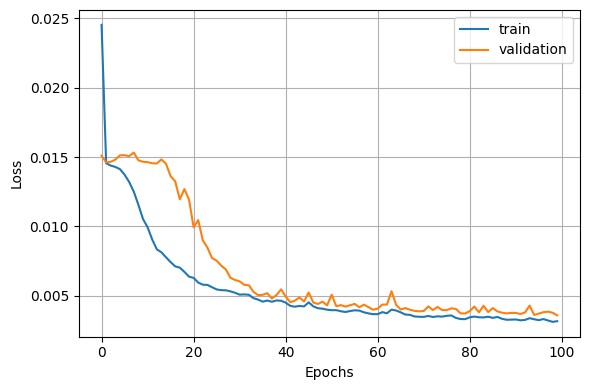

In [9]:
ae = make_model()
print('# of paramters: {:,}'.format(ae.count_params()))
ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss=MeanSquaredError())
start = time()
fit = ae.fit(x=X_train, y=y_train,
             epochs = 100,
             batch_size = 16,
             validation_split = 0.2,
             shuffle = True,
             verbose = 0)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(fit)

In [10]:
y_train_pred = ae.predict(X_train, verbose=0).squeeze()
y_test_pred = ae.predict(X_test, verbose=0).squeeze()

y_train_pred = (y_train_pred - y_train_pred.min()) / (y_train_pred.max() - y_train_pred.min())
y_test_pred = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())

print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

2025-05-20 14:35:32.890559: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng13{} for conv %cudnn-conv-bias-activation.34 = (f32[32,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,128,128]{3,2,1,0} %bitcast.1126, f32[16,64,3,3]{3,2,1,0} %bitcast.1133, f32[16]{0} %bitcast.1135), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="faultAE_1/conv2d_7_1/convolution" source_file="/home/mmorales/miniconda3/envs/flow/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-20 14:35:32.892991: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 21.152702984

Pred - train: (500, 256, 256) | test: (106, 256, 256)


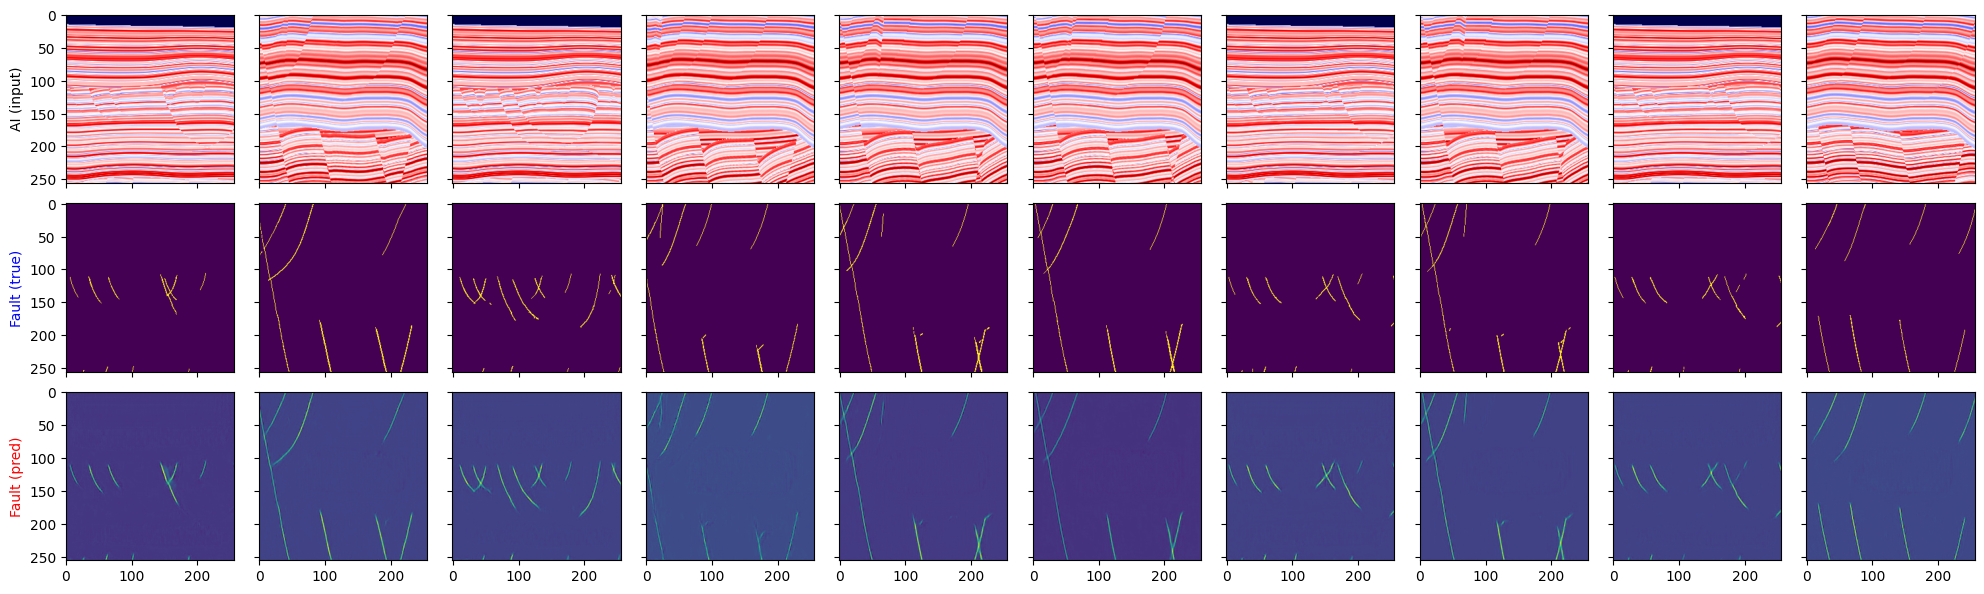

In [12]:
fig, axs = plt.subplots(3, 10, figsize=(20,6), sharex=True, sharey=True)
for j in range(10):
    k = j * 5
    ax1, ax2, ax3 = axs[:,j]
    ax1.imshow(X_test[k], cmap='seismic', vmin=0, vmax=1)
    ax2.imshow(y_test[k])
    ax3.imshow(y_test_pred[k])
    [a.set_ylabel(['AI (input)', 'Fault (true)', 'Fault (pred)'][i], color=['k','b','r'][i]) for i,a in enumerate(axs[:,0])]
plt.tight_layout()
plt.show()

In [ ]:
confusion_train = 1
confusion_test = 1

accuracy_train = 1
accuracy_test = 1

f1_train = 1
f1_test = 1

print('Train - Accuracy: {:.4f} | F1 score: {:.3f}'.format(accuracy_train, f1_train))
print('Test  - Accuracy: {:.4f} | F1 score: {:.3f}'.format(accuracy_test, f1_test))

plt.figure()
plt.imshow(confusion_train)

plt.figure()
plt.imshow(confusion_test)

In [14]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = 1

mse_train = 1
mse_test = 1

ssim_train = 1
ssim_test = 1

print('Train - R2: {:.2f} | MSE: {:.4f} | SSIM: {:.3f}'.format(r2_train, mse_train, ssim_train))
print('Test  - R2: {:.2f} | MSE: {:.4f} | SSIM: {:.3f}'.format(r2_test, mse_test, ssim_test))

ValueError: Found array with dim 4. None expected <= 2.

***
# END